<a href="https://colab.research.google.com/github/skj092/monocular-depth-estimation/blob/main/mde_pt_keras_doc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -qq pytorch_msssim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.0 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DownscaleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, stride=1):
        super().__init__()
        self.convA = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.convB = nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding)
        self.reluA = nn.LeakyReLU(0.2)
        self.reluB = nn.LeakyReLU(0.2)
        self.bn2a = nn.BatchNorm2d(out_channels)
        self.bn2b = nn.BatchNorm2d(out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        d = self.convA(x)
        x = self.bn2a(d)
        x = self.reluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.reluB(x)

        x = x + d
        p = self.pool(x)
        return x, p


class UpscaleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, stride=1):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='nearest')
        self.convA = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.convB = nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding)
        self.reluA = nn.LeakyReLU(0.2)
        self.reluB = nn.LeakyReLU(0.2)
        self.bn2a = nn.BatchNorm2d(out_channels)
        self.bn2b = nn.BatchNorm2d(out_channels)

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        x = self.convA(x)
        x = self.bn2a(x)
        x = self.reluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.reluB(x)
        return x


class BottleNeckBlock(nn.Module):
    def __init__(self, channels, kernel_size=3, padding=1, stride=1):
        super().__init__()
        self.convA = nn.Conv2d(channels, channels, kernel_size, stride, padding)
        self.convB = nn.Conv2d(channels, channels, kernel_size, stride, padding)
        self.reluA = nn.LeakyReLU(0.2)
        self.reluB = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.convA(x)
        x = self.reluA(x)
        x = self.convB(x)
        x = self.reluB(x)
        return x


class DepthEstimationModel(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        filters = [16, 32, 64, 128, 256]

        self.down1 = DownscaleBlock(in_channels, filters[0])           # 3 → 16
        self.down2 = DownscaleBlock(filters[0], filters[1])            # 16 → 32
        self.down3 = DownscaleBlock(filters[1], filters[2])            # 32 → 64
        self.down4 = DownscaleBlock(filters[2], filters[3])            # 64 → 128

        self.bottleneck = BottleNeckBlock(filters[3])                  # 128 → 128

        self.up1 = UpscaleBlock(filters[3] + filters[3], filters[2])   # 128 + 128 → 64
        self.up2 = UpscaleBlock(filters[2] + filters[2], filters[1])   # 64 + 64 → 32
        self.up3 = UpscaleBlock(filters[1] + filters[1], filters[0])   # 32 + 32 → 16
        self.up4 = UpscaleBlock(filters[0] + filters[0], filters[0])   # 16 + 16 → 16

        self.final_conv = nn.Conv2d(filters[0], 1, kernel_size=1)
        self.activation = nn.Tanh()

    def forward(self, x):
        s1, p1 = self.down1(x)
        s2, p2 = self.down2(p1)
        s3, p3 = self.down3(p2)
        s4, p4 = self.down4(p3)

        b = self.bottleneck(p4)

        x = self.up1(b, s4)
        x = self.up2(x, s3)
        x = self.up3(x, s2)
        x = self.up4(x, s1)

        x = self.final_conv(x)
        x = self.activation(x)
        return x



In [ ]:
import torch
import torch.nn.functional as F
from torchvision.models._utils import IntermediateLayerGetter

# Optional: SSIM implementation
import pytorch_msssim

def image_gradients(image):
    if image.ndim != 4:
        raise ValueError(
            f"image_gradients expects a 4D tensor [B, C, H, W], not {image.shape}."
        )

    dy = image[:, :, 1:, :] - image[:, :, :-1, :]
    dx = image[:, :, :, 1:] - image[:, :, :, :-1]

    # Pad to retain original shape
    dy = F.pad(dy, (0, 0, 0, 1), mode="constant", value=0)
    dx = F.pad(dx, (0, 1, 0, 0), mode="constant", value=0)

    return dy, dx

def calculate_loss(target, pred, ssim_loss_weight=1.0, l1_loss_weight=1.0, edge_loss_weight=1.0, max_val=1.0):
    # Image gradients
    dy_true, dx_true = image_gradients(target)
    dy_pred, dx_pred = image_gradients(pred)

    weights_x = torch.exp(torch.mean(torch.abs(dx_true)))
    weights_y = torch.exp(torch.mean(torch.abs(dy_true)))

    # Smoothness loss
    smoothness_x = dx_pred * weights_x
    smoothness_y = dy_pred * weights_y
    depth_smoothness_loss = torch.mean(torch.abs(smoothness_x)) + torch.mean(torch.abs(smoothness_y))

    # SSIM loss (assuming images are in [0, 1] range)
    ssim_loss = 1 - pytorch_msssim.ssim(pred, target, data_range=max_val, size_average=True)

    # L1 Loss
    l1_loss = torch.mean(torch.abs(target - pred))

    # Final loss
    loss = (
        ssim_loss_weight * ssim_loss
        + l1_loss_weight * l1_loss
        + edge_loss_weight * depth_smoothness_loss
    )
    return loss

if __name__ == "__main__":
    # Example usage
    target = torch.rand(1, 3, 256, 256)  # Random target image
    pred = torch.rand(1, 3, 256, 256)    # Random predicted image

    loss = calculate_loss(target, pred)
    print(f"Calculated loss: {loss.item()}")


Calculated loss: 2.2504239082336426


In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
import torch
from sklearn.model_selection import train_test_split
import wandb
# from dotenv import load_dotenv
# from loss_fns import calculate_loss
# from model2 import DepthEstimationModel
from fastai.vision.all import *
import keras
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt

# Data Download
# annotation_folder = "/dataset/"
# if not os.path.exists(os.path.abspath(".") + annotation_folder):
#     annotation_zip = keras.utils.get_file(
#         "val.tar.gz",
#         cache_subdir=os.path.abspath("."),
#         origin="http://diode-dataset.s3.amazonaws.com/val.tar.gz",
#         extract=True,
#     )

# wandb.login(key=os.getenv("WANDB_API_KEY"))
# wandb.init(project="DepthEstimation", name="FastAI_Training",)

# load_dotenv()


# data loading and preprocessing
train_path = "val_extracted/val/indoors"
filelist = []
for root, dirs, files in os.walk(train_path):
    for file in files:
        filelist.append(os.path.join(root, file))

filelist.sort()

images = sorted([x for x in filelist if x.endswith(".png")])
depths = sorted([x for x in filelist if x.endswith("_depth.npy")])
masks = sorted([x for x in filelist if x.endswith("_depth_mask.npy")])

# Get base names
depth_bases = {os.path.basename(x).replace("_depth.npy", "") for x in depths}
mask_bases = {os.path.basename(x).replace("_depth_mask.npy", "") for x in masks}
valid_bases = depth_bases & mask_bases

# Filter valid files only
valid_images = [x for x in images if os.path.basename(x).replace(".png", "") in valid_bases]
valid_depths = [x for x in depths if os.path.basename(x).replace("_depth.npy", "") in valid_bases]
valid_masks = [x for x in masks if os.path.basename(x).replace("_depth_mask.npy", "") in valid_bases]

# Build DataFrame
data = {
    "image": valid_images,
    "depth": valid_depths,
    "mask": valid_masks,
}
df = pd.DataFrame(data)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
print(f"Total train samples: {len(df)}")
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)
print(f"Training samples: {len(train_df)}, Validation samples: {len(valid_df)}")

# Dataset and DataLoader setup
def open_image(fn):
    img = cv2.imread(fn)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256))
    return torch.tensor(img, dtype=torch.float32).permute(2, 0, 1) / 255.0

def load_depth_masked(row):
    depth = np.load(row['depth']).squeeze()
    mask = np.load(row['mask']) > 0
    epsilon = 1e-6
    max_depth = min(300, np.percentile(depth[mask], 99))
    depth = np.clip(depth, epsilon, max_depth)
    depth_log = np.zeros_like(depth)
    depth_log[mask] = np.log(depth[mask])
    depth_log = np.clip(depth_log, np.log(epsilon), np.log(max_depth))
    depth_log = cv2.resize(depth_log, (256, 256))
    with np.errstate(invalid='ignore', divide='ignore'):
        depth_norm = (depth_log / np.log(max_depth))
        depth_norm = np.nan_to_num(depth_norm, nan=0.0, posinf=0.0, neginf=0.0)
    depth_uint8 = (depth_norm * 255).astype(np.uint8)
    return torch.tensor(depth_uint8, dtype=torch.float32).unsqueeze(0) / 255.0  # Add channel dimension and normalize

def get_x(row): return open_image(row['image'])
def get_y(row): return load_depth_masked(row)

class DepthDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        x = get_x(row)
        y = get_y(row)
        return x, y

train_ds = DepthDataset(train_df)
valid_ds = DepthDataset(valid_df)
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_ds, batch_size=16, shuffle=False, num_workers=4)

# Model and loss function
class DepthWrapper(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.model = base_model
    def forward(self, x):
        out = self.model(x)
        return F.interpolate(out, size=(256, 256), mode='bilinear', align_corners=False)

class CombinedDepthLoss:
    def __init__(self, ssim_loss_weight=1.0, l1_loss_weight=1.0, edge_loss_weight=1.0):
        self.ssim_loss_weight = ssim_loss_weight
        self.l1_loss_weight = l1_loss_weight
        self.edge_loss_weight = edge_loss_weight
    def __call__(self, pred, target):
        return calculate_loss(
            target,
            pred,
            ssim_loss_weight=self.ssim_loss_weight,
            l1_loss_weight=self.l1_loss_weight,
            edge_loss_weight=self.edge_loss_weight,
            max_val=1.0
        )

loss_func = CombinedDepthLoss(ssim_loss_weight=1.0, l1_loss_weight=1.0, edge_loss_weight=1.0)

# Metrics
def abs_rel(pred, target):
    pred, target = pred.squeeze(), target.squeeze()
    mask = target > 1e-3  # Stricter threshold to avoid division by near-zero
    if mask.sum() == 0:
        return float('nan')
    return torch.mean(torch.abs(pred[mask] - target[mask]) / target[mask])

def log10_mae(pred, target):
    pred, target = pred.squeeze(), target.squeeze()
    mask = (target > 1e-3) & (pred > 1e-3)  # Mask non-positive values
    if mask.sum() == 0:
        return float('nan')
    return torch.mean(torch.abs(torch.log10(pred[mask]) - torch.log10(target[mask])))

def log10_rmse(pred, target):
    pred, target = pred.squeeze(), target.squeeze()
    mask = (target > 1e-3) & (pred > 1e-3)
    if mask.sum() == 0:
        return float('nan')
    return torch.sqrt(torch.mean((torch.log10(pred[mask]) - torch.log10(target[mask])) ** 2))

def threshold_accuracy(thresh):
    def _inner(pred, target):
        pred, target = pred.squeeze(), target.squeeze()
        mask = target > 1e-3
        if mask.sum() == 0:
            return float('nan')
        ratio = torch.max(pred[mask] / target[mask], target[mask] / pred[mask])
        return torch.mean((ratio < thresh).float())
    return _inner

delta1 = threshold_accuracy(1.25)
delta2 = threshold_accuracy(1.25 ** 2)
delta3 = threshold_accuracy(1.25 ** 3)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = DepthEstimationModel(in_channels=3)
model = model.to(device)

# Optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-4, steps_per_epoch=len(train_dl), epochs=10)
# Training loop

def train_epoch(model, train_dl, optimizer, loss_func, device):
    model.train()
    total_loss = 0.0
    for x, y in tqdm(train_dl):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(x)
        loss = loss_func(pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_dl)
def validate_epoch(model, valid_dl, loss_func, device):
    model.eval()
    total_loss = 0.0
    metrics = {
        'abs_rel': 0.0,
        'log10_mae': 0.0,
        'log10_rmse': 0.0,
        'delta1': 0.0,
        'delta2': 0.0,
        'delta3': 0.0
    }
    with torch.no_grad():
        for x, y in tqdm(valid_dl):
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = loss_func(pred, y)
            total_loss += loss.item()
            metrics['abs_rel'] += abs_rel(pred, y).item()
            metrics['log10_mae'] += log10_mae(pred, y).item()
            metrics['log10_rmse'] += log10_rmse(pred, y).item()
            metrics['delta1'] += delta1(pred, y).item()
            metrics['delta2'] += delta2(pred, y).item()
            metrics['delta3'] += delta3(pred, y).item()
    num_batches = len(valid_dl)
    return (total_loss / num_batches, {k: v / num_batches for k, v in metrics.items()})

def train_model(model, train_dl, valid_dl, optimizer, loss_func, device, epochs=10):
    for epoch in range(epochs):
        train_loss = train_epoch(model, train_dl, optimizer, loss_func, device)
        valid_loss, metrics = validate_epoch(model, valid_dl, loss_func, device)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")
        print(f"Metrics: {metrics}")

        # Update learning rate
        # scheduler.step()
        # Log to Weights & Biases
        # wandb.log({
        #     'epoch': epoch + 1,
        #     'train_loss': train_loss,
        #     'valid_loss': valid_loss,
        #     **metrics
        # })
    return model



Total train samples: 325
Training samples: 260, Validation samples: 65


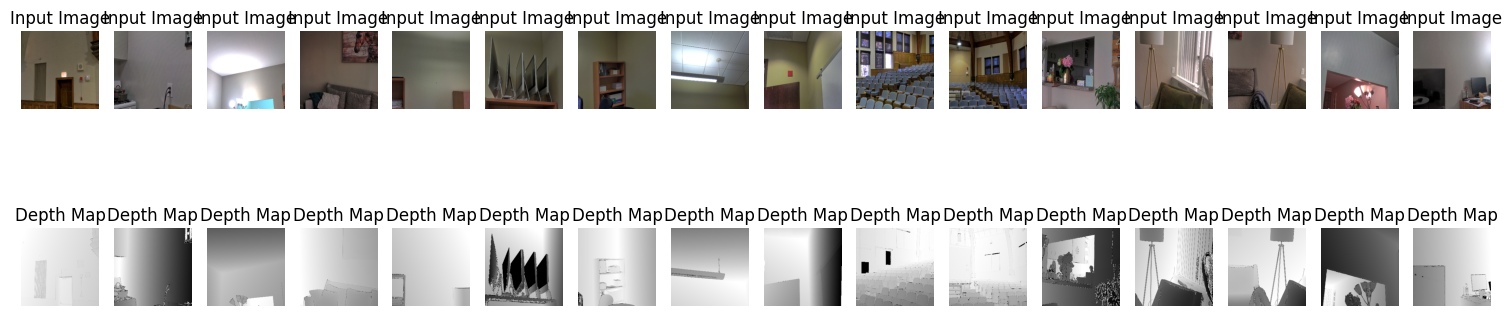

In [ ]:
# visualize a batch of data
def visualize_batch(dl):
    for x, y in dl:
        x = x.permute(0, 2, 3, 1).numpy()  # Convert to [B, H, W, C] format
        y = y.squeeze().numpy()  # Remove channel dimension
        fig, axes = plt.subplots(nrows=2, ncols=len(x), figsize=(15, 5))
        for i in range(len(x)):
            axes[0, i].imshow(x[i])
            axes[0, i].set_title('Input Image')
            axes[0, i].axis('off')
            axes[1, i].imshow(y[i], cmap='gray')
            axes[1, i].set_title('Depth Map')
            axes[1, i].axis('off')
        plt.tight_layout()
        plt.show()
        break  # Show only one batch

visualize_batch(train_dl)

In [ ]:
model = train_model(model, train_dl, valid_dl, optimizer, loss_func, device, epochs=10)
# Save the model
torch.save(model.state_dict(), 'depth_estimation_model.pth')

100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Epoch 1/10, Train Loss: 0.9547, Valid Loss: 1.4283
Metrics: {'abs_rel': 1.0771974086761475, 'log10_mae': 0.4141718626022339, 'log10_rmse': 0.5453800082206726, 'delta1': 0.3789456307888031, 'delta2': 0.4733757197856903, 'delta3': 0.5991589665412903}


100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch 2/10, Train Loss: 0.6013, Valid Loss: 0.5672
Metrics: {'abs_rel': 1.1433574974536895, 'log10_mae': 0.21519454717636108, 'log10_rmse': 0.30001955628395083, 'delta1': 0.2372887283563614, 'delta2': 0.4793007344007492, 'delta3': 0.8515882968902588}


100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch 3/10, Train Loss: 0.5420, Valid Loss: 0.5251
Metrics: {'abs_rel': 1.2307196080684661, 'log10_mae': 0.1919283002614975, 'log10_rmse': 0.29443712830543517, 'delta1': 0.3148992359638214, 'delta2': 0.7918852686882019, 'delta3': 0.8583269596099854}


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Epoch 4/10, Train Loss: 0.5033, Valid Loss: 0.4974
Metrics: {'abs_rel': 1.2780699253082275, 'log10_mae': 0.1856194794178009, 'log10_rmse': 0.29331685304641725, 'delta1': 0.32735579907894136, 'delta2': 0.8118273019790649, 'delta3': 0.855766761302948}


100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


Epoch 5/10, Train Loss: 0.4974, Valid Loss: 0.4971
Metrics: {'abs_rel': 1.2854738414287568, 'log10_mae': 0.1837220758199692, 'log10_rmse': 0.2941835284233093, 'delta1': 0.35132060647010804, 'delta2': 0.8102571487426757, 'delta3': 0.8531405210494996}


100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch 6/10, Train Loss: 0.4859, Valid Loss: 0.5015
Metrics: {'abs_rel': 1.2529841780662536, 'log10_mae': 0.18668000698089598, 'log10_rmse': 0.29583665132522585, 'delta1': 0.37123512029647826, 'delta2': 0.8061235070228576, 'delta3': 0.8521750330924988}


100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch 7/10, Train Loss: 0.4805, Valid Loss: 0.4916
Metrics: {'abs_rel': 1.3129569053649903, 'log10_mae': 0.1832097589969635, 'log10_rmse': 0.29733315408229827, 'delta1': 0.3833457589149475, 'delta2': 0.802946150302887, 'delta3': 0.8459383845329285}


100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch 8/10, Train Loss: 0.4755, Valid Loss: 0.4939
Metrics: {'abs_rel': 1.31666259765625, 'log10_mae': 0.18401605188846587, 'log10_rmse': 0.2989142417907715, 'delta1': 0.4007490247488022, 'delta2': 0.8023472785949707, 'delta3': 0.8463412523269653}


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch 9/10, Train Loss: 0.4750, Valid Loss: 0.4895
Metrics: {'abs_rel': 1.3042056381702423, 'log10_mae': 0.18255765438079835, 'log10_rmse': 0.29880057871341703, 'delta1': 0.4199628233909607, 'delta2': 0.8006356835365296, 'delta3': 0.8443087935447693}


100%|██████████| 5/5 [00:04<00:00,  1.23it/s]

Epoch 10/10, Train Loss: 0.4740, Valid Loss: 0.4836
Metrics: {'abs_rel': 1.3308680593967437, 'log10_mae': 0.18067992627620696, 'log10_rmse': 0.29957636892795564, 'delta1': 0.4440906912088394, 'delta2': 0.7969762206077575, 'delta3': 0.8410681128501892}


In [ ]:
import matplotlib.pyplot as plt

def visualize_predictions(model, valid_dl, device):
    model.eval()
    with torch.no_grad():
        for i, (x, y) in enumerate(valid_dl):
            x = x.to(device)
            pred = model(x)
            pred = F.interpolate(pred, size=(256, 256), mode='bilinear', align_corners=False)

            # Get only the first image from the batch
            pred_img = pred[0].cpu().squeeze().numpy()
            y_img = y[0].cpu().squeeze().numpy()

            # Convert to uint8 for visualization
            pred_vis = (pred_img * 255).astype(np.uint8)
            y_vis = (y_img * 255).astype(np.uint8)

            # Plot side-by-side
            fig, axs = plt.subplots(1, 2, figsize=(10, 4))
            axs[0].imshow(pred_vis, cmap='gray')
            axs[0].set_title(f'Predicted Depth {i}')
            axs[0].axis('off')

            axs[1].imshow(y_vis, cmap='gray')
            axs[1].set_title(f'Ground Truth Depth {i}')
            axs[1].axis('off')

            plt.tight_layout()
            plt.show()

            if i >= 4:  # Show only 5 batches
                break


In [ ]:
visualize_predictions(model, valid_dl, device)